In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from  xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [78]:
df_train = pd.read_csv('data_train.csv')
df_prom = pd.read_csv('data_prom.csv')
df_train.drop(['id'], inplace=True, axis=1)
df_prom.drop(['id'], inplace=True, axis=1)
df_all = pd.concat((df_train, df_prom)).reset_index(drop=True)
len_train = len(df_train)

In [79]:
for col in df_train.columns:
    df_all[col] = np.where((df_all[col] == '?'), np.nan, df_all[col])

In [80]:
df_all.head(5)

,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,...,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,resolved_by,target
0,1.0,0.0,0.0,0.0,1.0,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,...,NaN,1.0,0.0,Do Not Notify,NaN,NaN,NaN,NaN,Resolved by 149,130.0
1,1.0,0.0,0.0,0.0,1.0,Caller 2403,Opened by 397,29/2/2016 04:40,Created by 171,29/2/2016 04:57,...,Resolver 89,1.0,0.0,Do Not Notify,NaN,NaN,NaN,NaN,Resolved by 81,149.0
2,1.0,0.0,0.0,4.0,1.0,Caller 4416,Opened by 8,29/2/2016 06:10,NaN,NaN,...,NaN,1.0,0.0,Do Not Notify,Problem ID 2,NaN,NaN,NaN,Resolved by 5,140.0
3,1.0,0.0,0.0,0.0,1.0,Caller 4491,Opened by 180,29/2/2016 06:38,Created by 81,29/2/2016 06:42,...,Resolver 125,1.0,0.0,Do Not Notify,NaN,NaN,NaN,NaN,Resolved by 113,174.0
4,1.0,1.0,0.0,5.0,1.0,Caller 3765,Opened by 180,29/2/2016 06:58,Created by 81,29/2/2016 07:26,...,NaN,1.0,0.0,Do Not Notify,NaN,NaN,NaN,NaN,Resolved by 62,129.0


In [81]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16137 entries, 0 to 16136
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   active                   16137 non-null  float64
 1   reassignment_count       16137 non-null  float64
 2   reopen_count             16137 non-null  float64
 3   sys_mod_count            16137 non-null  float64
 4   made_sla                 16137 non-null  float64
 5   caller_id                16135 non-null  object 
 6   opened_by                15612 non-null  object 
 7   opened_at                16137 non-null  object 
 8   sys_created_by           9783 non-null   object 
 9   sys_created_at           9783 non-null   object 
 10  sys_updated_by           16137 non-null  object 
 11  sys_updated_at           16137 non-null  object 
 12  contact_type             16137 non-null  object 
 13  location                 16091 non-null  object 
 14  category              

In [82]:
df_all.describe()

,active,reassignment_count,reopen_count,sys_mod_count,made_sla,knowledge,u_priority_confirmation,target
count,16137.0,16137.000000,16137.0,16137.000000,16137.0,16137.000000,16137.000000,10572.000000
mean,1.0,0.665427,0.0,1.568817,1.0,0.153126,0.000744,341.463678
std,0.0,1.110488,0.0,2.957095,0.0,0.360120,0.027260,451.432343
min,1.0,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.0,0.000000,1.0,0.000000,0.000000,125.000000
50%,1.0,0.000000,0.0,1.000000,1.0,0.000000,0.000000,213.000000
75%,1.0,1.000000,0.0,2.000000,1.0,0.000000,0.000000,402.000000
max,1.0,13.000000,0.0,64.000000,1.0,1.000000,1.000000,5380.000000


In [83]:
df_all_na = (df_all.isnull().sum() / len(df_all)) * 100
df_all_na = df_all_na.sort_values(ascending=False)
df_all_na

caused_by                  99.987606
vendor                     99.919440
cmdb_ci                    99.770713
rfc                        99.665365
problem_id                 98.958914
assigned_to                41.197249
sys_created_at             39.375349
sys_created_by             39.375349
target                     34.485964
u_symptom                  23.474004
assignment_group            9.295408
opened_by                   3.253393
subcategory                 0.303650
location                    0.285059
category                    0.117742
resolved_by                 0.049576
caller_id                   0.012394
knowledge                   0.000000
reopen_count                0.000000
sys_mod_count               0.000000
made_sla                    0.000000
notify                      0.000000
u_priority_confirmation     0.000000
sys_updated_by              0.000000
sys_updated_at              0.000000
priority                    0.000000
urgency                     0.000000
i

<AxesSubplot:>

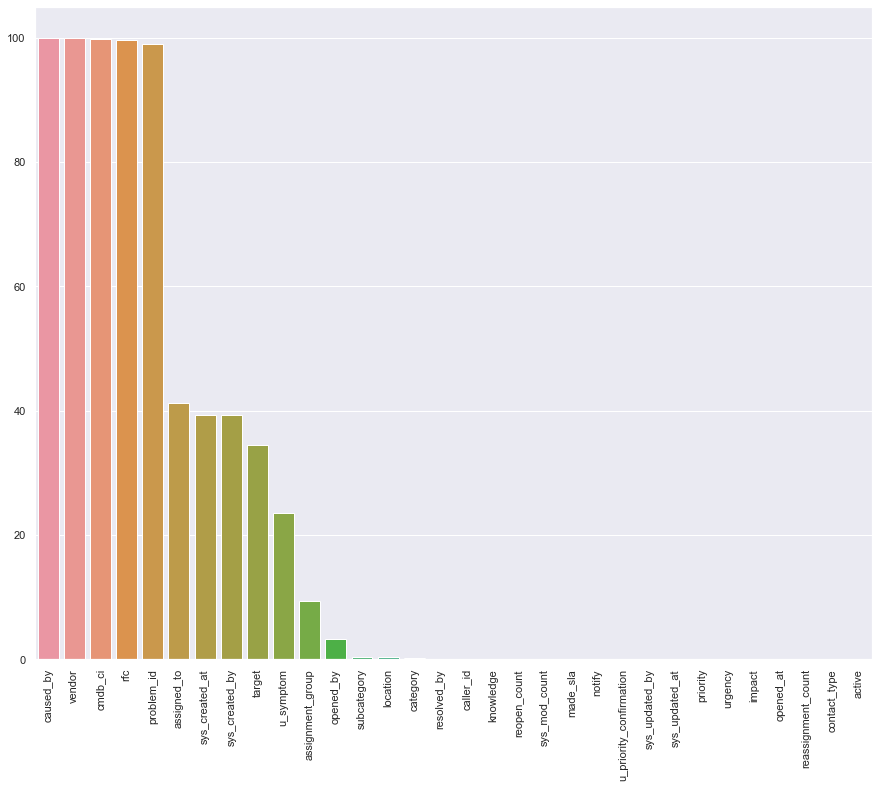

In [84]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=df_all_na.index, y=df_all_na)

In [85]:
df_all.drop(['caused_by', 'vendor', 'cmdb_ci', 'rfc', 'problem_id'], axis=1, inplace=True)

In [86]:
def target_table(col: str):
    return df_all[[col, 'target']].groupby([col], as_index=False).mean().sort_values(by='target', ascending=False)

In [87]:
target_table('assigned_to')

,assigned_to,target
8,Resolver 114,4651.000000
44,Resolver 160,4628.000000
14,Resolver 124,4368.000000
137,Resolver 64,3986.142857
80,Resolver 217,3753.555556
...,...,...
125,Resolver 46,NaN
130,Resolver 50,NaN
131,Resolver 52,NaN
152,Resolver 9,NaN


In [88]:
for col in df_all.columns:
    if col != 'target' and target_table(col).shape == (2, 2):
        print(target_table(col))

  contact_type      target
1        Phone  341.480258
0        Email  336.611111
   knowledge      target
1        1.0  460.184945
0        0.0  305.250833
   u_priority_confirmation      target
0                      0.0  341.492711
1                      1.0  303.125000
          notify      target
0  Do Not Notify  341.480258
1     Send Email  336.611111


In [89]:
df_all.drop(['active', 'reopen_count', 'made_sla', 'sys_created_at'], axis=1, inplace=True)

In [90]:
df_all['sys_updated_at'] = pd.to_datetime(df_all['sys_updated_at'])
df_all['opened_at'] = pd.to_datetime(df_all['opened_at'])
df_all['opened_at_hour'] = df_all['opened_at'].dt.hour
df_all['sys_updated_at_hour'] = df_all['sys_updated_at'].dt.hour
df_all.drop(['sys_updated_at', 'opened_at'], axis=1, inplace=True)
df_all

,reassignment_count,sys_mod_count,caller_id,opened_by,sys_created_by,sys_updated_by,contact_type,location,category,subcategory,...,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,resolved_by,target,opened_at_hour,sys_updated_at_hour
0,0.0,0.0,Caller 2403,Opened by 8,Created by 6,Updated by 21,Phone,Location 143,Category 55,Subcategory 170,...,3 - Moderate,Group 56,NaN,1.0,0.0,Do Not Notify,Resolved by 149,130.0,1,1
1,0.0,0.0,Caller 2403,Opened by 397,Created by 171,Updated by 746,Phone,Location 165,Category 40,Subcategory 215,...,3 - Moderate,Group 70,Resolver 89,1.0,0.0,Do Not Notify,Resolved by 81,149.0,4,4
2,0.0,4.0,Caller 4416,Opened by 8,NaN,Updated by 21,Phone,Location 204,Category 20,Subcategory 125,...,3 - Moderate,Group 70,NaN,1.0,0.0,Do Not Notify,Resolved by 5,140.0,6,2
3,0.0,0.0,Caller 4491,Opened by 180,Created by 81,Updated by 340,Phone,Location 204,Category 9,Subcategory 97,...,3 - Moderate,Group 25,Resolver 125,1.0,0.0,Do Not Notify,Resolved by 113,174.0,6,6
4,1.0,5.0,Caller 3765,Opened by 180,Created by 81,Updated by 241,Phone,Location 93,Category 53,Subcategory 168,...,2 - High,Group 23,NaN,1.0,0.0,Do Not Notify,Resolved by 62,129.0,6,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16132,0.0,0.0,Caller 249,Opened by 17,Created by 10,Updated by 44,Phone,Location 204,Category 57,Subcategory 170,...,3 - Moderate,Group 56,Resolver 167,0.0,0.0,Do Not Notify,Resolved by 150,NaN,20,20
16133,0.0,0.0,Caller 4793,Opened by 443,NaN,Updated by 908,Phone,Location 204,Category 32,Subcategory 174,...,3 - Moderate,Group 70,NaN,0.0,0.0,Do Not Notify,Resolved by 189,NaN,20,20
16134,0.0,0.0,Caller 5203,Opened by 58,NaN,Updated by 908,Phone,Location 108,Category 26,Subcategory 174,...,3 - Moderate,Group 70,NaN,0.0,0.0,Do Not Notify,Resolved by 29,NaN,20,20
16135,0.0,1.0,Caller 3617,Opened by 17,Created by 10,Updated by 44,Phone,Location 172,Category 54,Subcategory 177,...,3 - Moderate,Group 33,Resolver 159,0.0,0.0,Do Not Notify,Resolved by 143,NaN,12,12


In [91]:
for col in ['opened_at_hour', 'sys_updated_at_hour']:
    df_all.loc[df_all[col] <= 10, col] = 0
    df_all.loc[df_all[col] > 10, col] = 1

In [92]:
for col in df_all.columns:
    if col != 'target':
        df_all[col].fillna('?', inplace=True)

In [93]:
def fillna_closer(col: str):
    table = target_table(col)
    idx = df_train.loc[df_train[col] == '?'].index.to_list()
    for index in idx:
        closer = min(table['target'], key=lambda x: abs(x - df_train['target'][index]))
        index_2 = table.loc[table['target'] == closer].index.to_list()
        df_train[col][index] = table[col][index_2[0]]

In [94]:
df_train = df_all[:len_train]
df_prom = df_all[len_train:]
df_prom.drop(['target'], axis=1, inplace=True)

C:\Users\kloko\AppData\Local\Temp\ipykernel_8040\168206875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prom.drop(['target'], axis=1, inplace=True)


In [95]:
for col in df_train.columns:
    if col != 'target':
        fillna_closer(col)

C:\Users\kloko\AppData\Local\Temp\ipykernel_8040\4007128504.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[col][index] = table[col][index_2[0]]
C:\Users\kloko\AppData\Local\Temp\ipykernel_8040\4007128504.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[col][index] = table[col][index_2[0]]
C:\Users\kloko\AppData\Local\Temp\ipykernel_8040\4007128504.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[co

In [99]:
for col in df_prom.columns:
    df_prom[col] = np.where((df_prom[col] == '?'), np.nan, df_prom[col])

C:\Users\kloko\AppData\Local\Temp\ipykernel_8040\3770099121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prom[col] = np.where((df_prom[col] == '?'), np.nan, df_prom[col])


In [101]:
for col in df_prom.columns:
    df_prom[col] = df_prom[col].fillna(df_train[col].mode()[0])

C:\Users\kloko\AppData\Local\Temp\ipykernel_8040\1417942855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prom[col] = df_prom[col].fillna(df_train[col].mode()[0])
C:\Users\kloko\AppData\Local\Temp\ipykernel_8040\1417942855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prom[col] = df_prom[col].fillna(df_train[col].mode()[0])
C:\Users\kloko\AppData\Local\Temp\ipykernel_8040\1417942855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [104]:
df_all = pd.concat((df_train, df_prom)).reset_index(drop=True)

In [105]:
df_all

,reassignment_count,sys_mod_count,caller_id,opened_by,sys_created_by,sys_updated_by,contact_type,location,category,subcategory,...,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,resolved_by,target,opened_at_hour,sys_updated_at_hour
0,0.0,0.0,Caller 2403,Opened by 8,Created by 6,Updated by 21,Phone,Location 143,Category 55,Subcategory 170,...,3 - Moderate,Group 56,Resolver 252,1.0,0.0,Do Not Notify,Resolved by 149,130.0,0.0,0.0
1,0.0,0.0,Caller 2403,Opened by 397,Created by 171,Updated by 746,Phone,Location 165,Category 40,Subcategory 215,...,3 - Moderate,Group 70,Resolver 89,1.0,0.0,Do Not Notify,Resolved by 81,149.0,0.0,0.0
2,0.0,4.0,Caller 4416,Opened by 8,Created by 55,Updated by 21,Phone,Location 204,Category 20,Subcategory 125,...,3 - Moderate,Group 70,Resolver 77,1.0,0.0,Do Not Notify,Resolved by 5,140.0,0.0,0.0
3,0.0,0.0,Caller 4491,Opened by 180,Created by 81,Updated by 340,Phone,Location 204,Category 9,Subcategory 97,...,3 - Moderate,Group 25,Resolver 125,1.0,0.0,Do Not Notify,Resolved by 113,174.0,0.0,0.0
4,1.0,5.0,Caller 3765,Opened by 180,Created by 81,Updated by 241,Phone,Location 93,Category 53,Subcategory 168,...,2 - High,Group 23,Resolver 252,1.0,0.0,Do Not Notify,Resolved by 62,129.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16132,0.0,0.0,Caller 249,Opened by 17,Created by 10,Updated by 44,Phone,Location 204,Category 57,Subcategory 170,...,3 - Moderate,Group 56,Resolver 167,0.0,0.0,Do Not Notify,Resolved by 150,NaN,1.0,1.0
16133,0.0,0.0,Caller 4793,Opened by 443,Created by 10,Updated by 908,Phone,Location 204,Category 32,Subcategory 174,...,3 - Moderate,Group 70,Resolver 5,0.0,0.0,Do Not Notify,Resolved by 189,NaN,1.0,1.0
16134,0.0,0.0,Caller 5203,Opened by 58,Created by 10,Updated by 908,Phone,Location 108,Category 26,Subcategory 174,...,3 - Moderate,Group 70,Resolver 5,0.0,0.0,Do Not Notify,Resolved by 29,NaN,1.0,1.0
16135,0.0,1.0,Caller 3617,Opened by 17,Created by 10,Updated by 44,Phone,Location 172,Category 54,Subcategory 177,...,3 - Moderate,Group 33,Resolver 159,0.0,0.0,Do Not Notify,Resolved by 143,NaN,1.0,1.0


In [106]:
le = LabelEncoder()
for col in df_all.columns:
    if col != 'target' and col!= 'reassignment_count' and col!= 'reassignment_count':
        df_all[col] = le.fit_transform(df_all[col])
df_all

,reassignment_count,sys_mod_count,caller_id,opened_by,sys_created_by,sys_updated_by,contact_type,location,category,subcategory,...,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,resolved_by,target,opened_at_hour,sys_updated_at_hour
0,0.0,0,1257,135,108,32,1,35,32,55,...,2,41,109,1,0,0,45,130.0,0,0
1,0.0,0,1257,86,44,161,1,50,21,91,...,2,56,152,1,0,0,170,149.0,0,0
2,0.0,4,3041,135,103,32,1,85,4,22,...,2,56,146,1,0,0,148,140.0,0,0
3,0.0,0,3099,23,119,62,1,85,40,203,...,2,14,16,1,0,0,12,174.0,0,0
4,1.0,5,2465,23,119,42,1,185,30,52,...,1,12,109,1,0,0,158,129.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16132,0.0,0,1338,20,2,83,1,85,34,55,...,2,41,50,0,0,0,47,NaN,1,1
16133,0.0,0,3363,100,2,207,1,85,14,59,...,2,56,130,0,0,0,82,NaN,1,1
16134,0.0,0,3720,127,2,207,1,5,9,59,...,2,56,130,0,0,0,127,NaN,1,1
16135,0.0,1,2328,20,2,83,1,57,31,62,...,2,23,43,0,0,0,42,NaN,1,1


<AxesSubplot:>

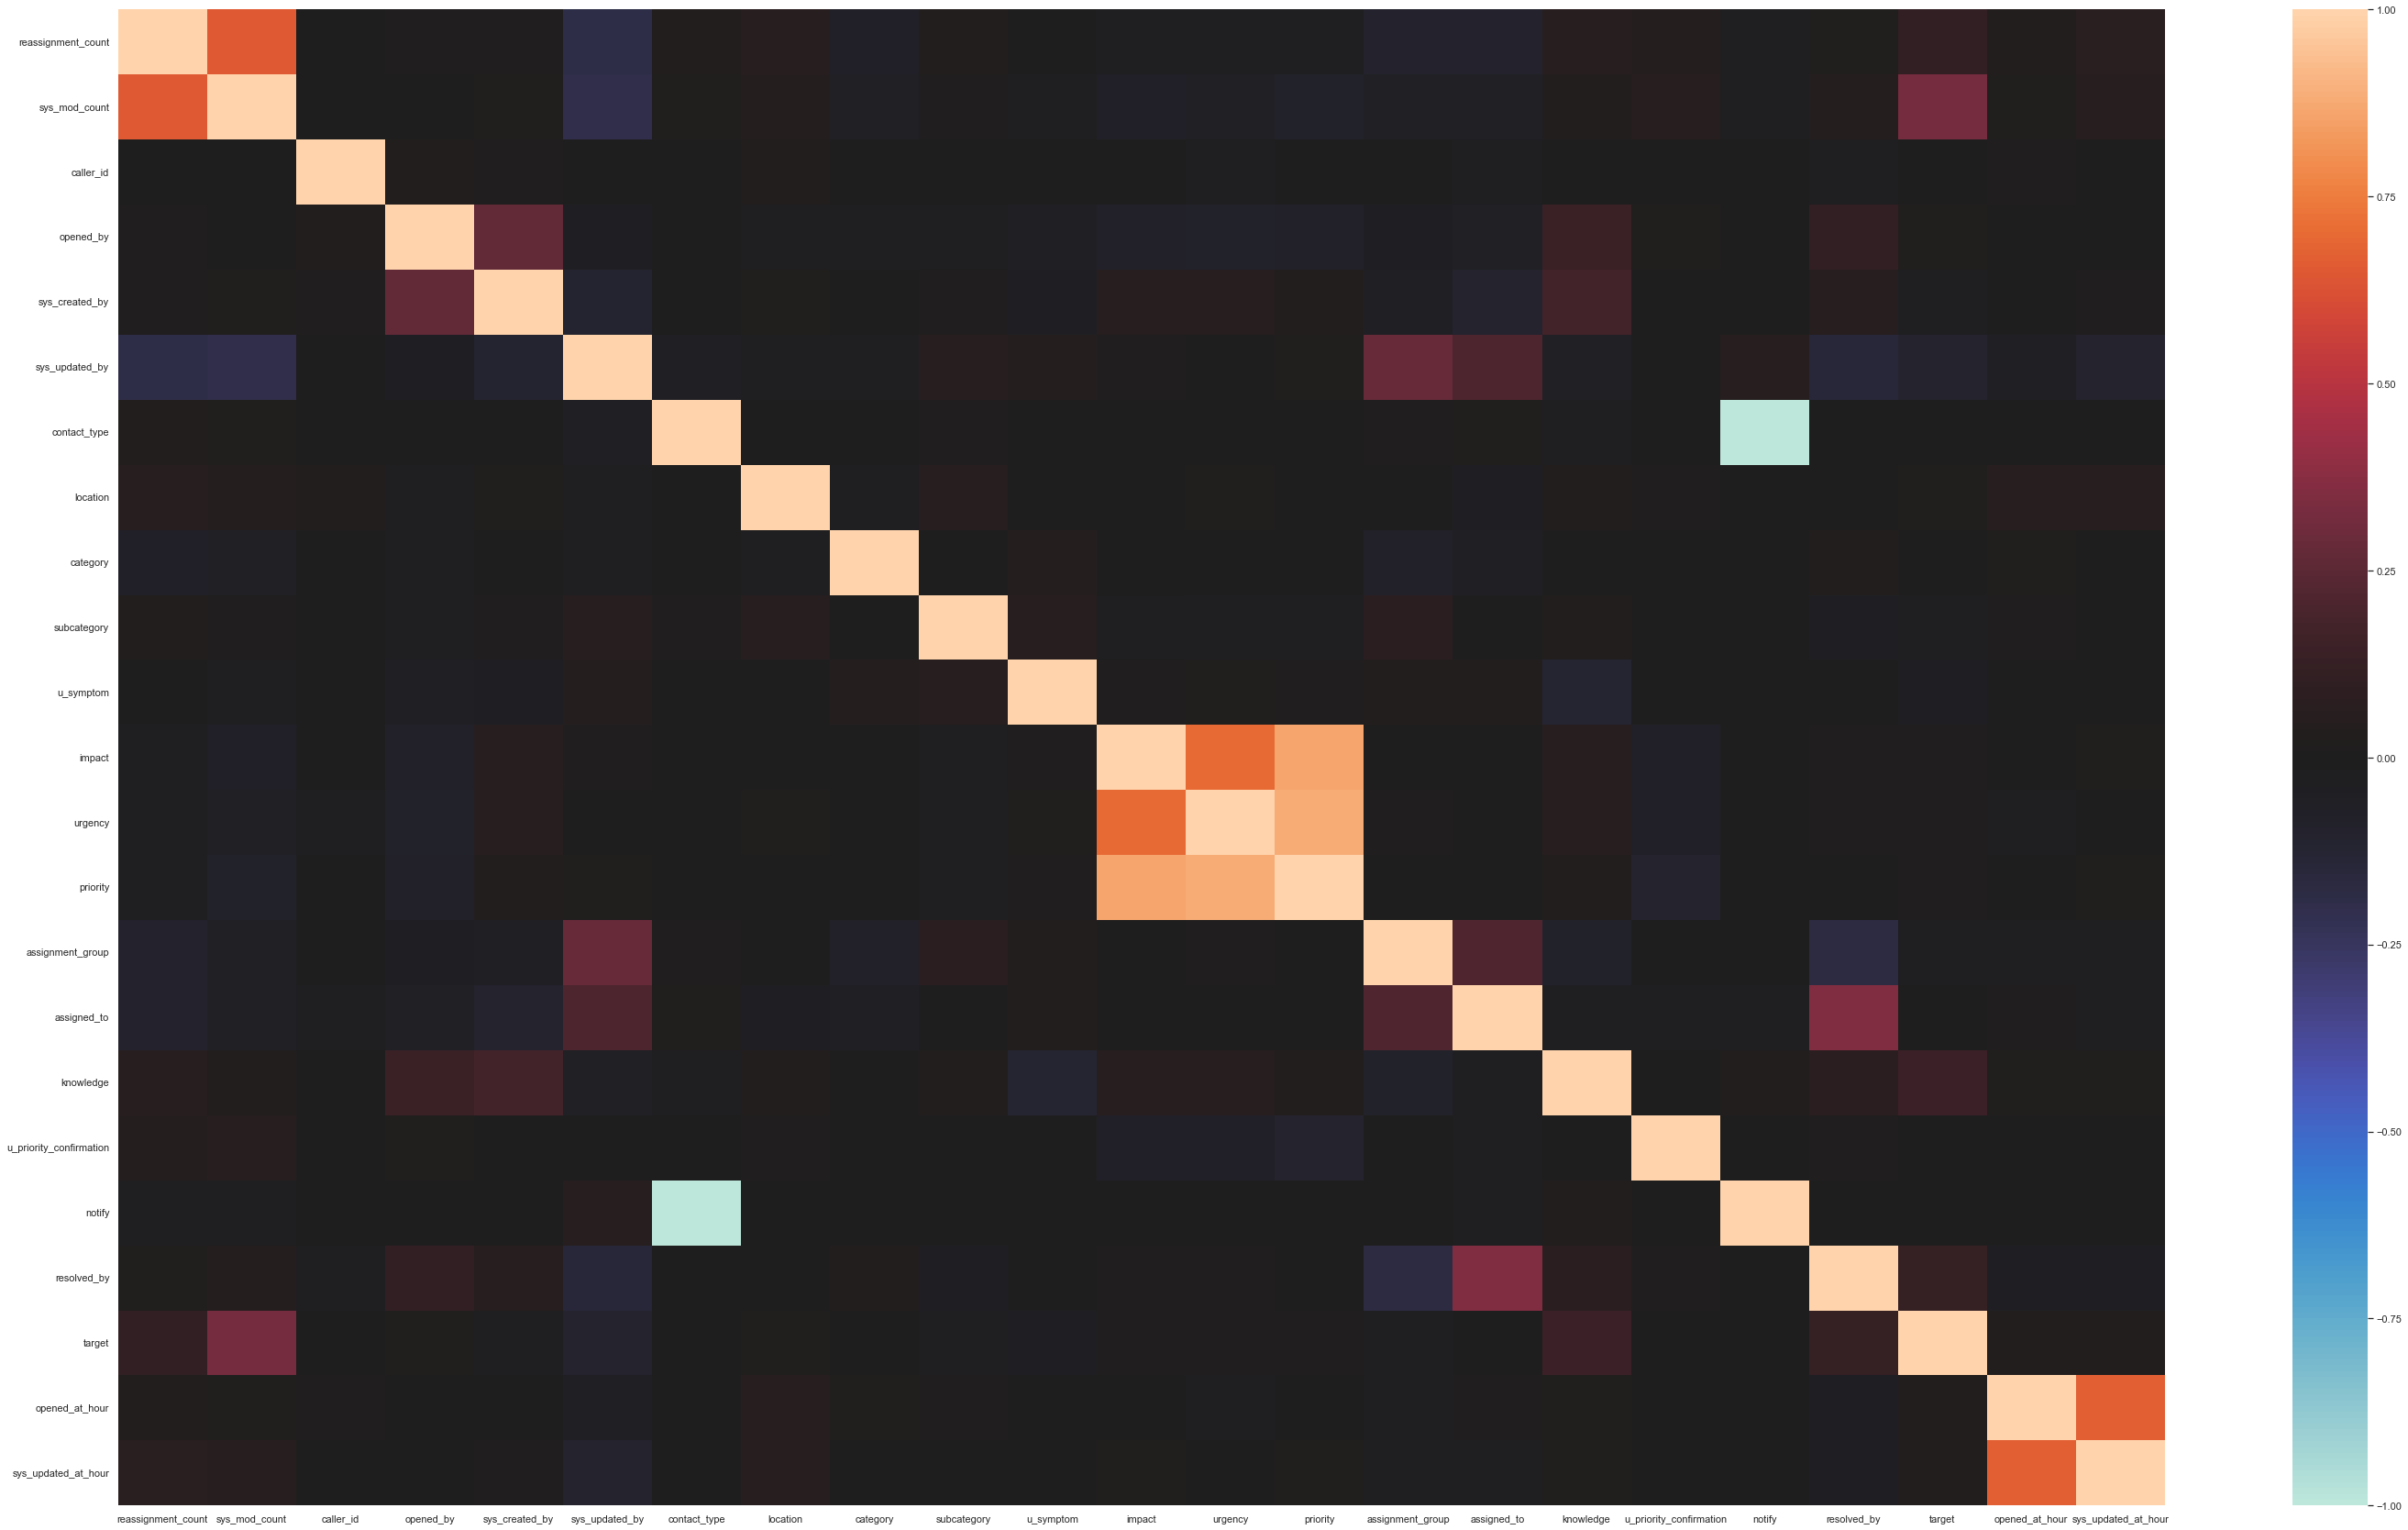

In [107]:
sns.set(rc = {'figure.figsize': (50, 30)})
sns.heatmap(df_all.corr(), vmin=-1, vmax=1, center=0)

In [108]:
df_all.drop(['contact_type', 'u_priority_confirmation'], axis=1, inplace=True)

In [109]:
df_train = df_all[:len_train]
df_prom = df_all[len_train:]
df_prom.drop(['target'], axis=1, inplace=True)
#df_train = df_train.drop(df_train[df_train.target > 1000].index)

C:\Users\kloko\AppData\Local\Temp\ipykernel_8040\1795649467.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prom.drop(['target'], axis=1, inplace=True)


In [21]:
'''
for i in df_train.columns:
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.scatter(x = df_train[i], y = df_train['target'])
    plt.ylabel('target', fontsize=13)
    plt.xlabel(i, fontsize=13)
    plt.show()
'''

"\nfor i in df_train.columns:\n    fig, ax = plt.subplots(figsize=(20, 5))\n    ax.scatter(x = df_train[i], y = df_train['target'])\n    plt.ylabel('target', fontsize=13)\n    plt.xlabel(i, fontsize=13)\n    plt.show()\n"

In [110]:
df_train_X = df_train.drop(['target'], axis=1)
df_train_y = df_train['target']

In [111]:
cv = RepeatedKFold(n_repeats=3, n_splits=3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(df_train_X, df_train_y, test_size=0.333, shuffle=True)

In [17]:
model = GradientBoostingRegressor()
param_dict = {
    'learning_rate': Real(0.001, 0.1),
    'n_estimators': Integer(500, 5000),
    'max_depth': Integer(1, 25),
    'min_samples_split': Integer(2, 200),
    'min_samples_leaf': Integer(1, 200),
    'subsample': Real(0.01, 1),
    'max_features': Categorical(['sqrt', 'log2', None])
}
BS = BayesSearchCV(model, param_dict, n_iter=100, random_state=0, cv=cv, n_jobs=-1, scoring='r2')
BS.fit(df_train_X, df_train_y)
print('Best score: %f, best params: %s' % (BS.best_score_, BS.best_params_))

Best score: 0.522749, best params: OrderedDict([('learning_rate', 0.07379130832304526), ('max_depth', 25), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 200), ('n_estimators', 2077), ('subsample', 0.5612064734420282)])


In [51]:
model_rgb = GradientBoostingRegressor(learning_rate=0.07, n_estimators=2077, max_depth=6, min_samples_split=200, min_samples_leaf=1, subsample=0.7, max_features='log2')
model_rgb.fit(X_train, y_train)
print(model_rgb.score(X_train, y_train))
model_rgb.score(X_test, y_test)

0.9456625505669551


0.6153737401473671

In [37]:
model = RandomForestRegressor()
param_dict = {
    'max_features': Categorical(['sqrt', 'log2', None]),
    'n_estimators': Integer(500, 5000),
    'max_depth': Integer(1, 25),
    'min_samples_split': Integer(2, 200),
    'min_samples_leaf': Integer(2, 200),
    'max_leaf_nodes': Integer(2, 200),
    'bootstrap': Categorical([True, False])

}
BS = BayesSearchCV(model, param_dict, n_iter=100, random_state=0, cv=cv, n_jobs=-1, scoring='r2')
BS.fit(df_train_X, df_train_y)
print('Best score: %f, best params: %s' % (BS.best_score_, BS.best_params_))

C:\Users\kloko\anaconda3\envs\case\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\kloko\anaconda3\envs\case\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\kloko\anaconda3\envs\case\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\kloko\anaconda3\envs\case\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\kloko\anaconda3\envs\case\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("

Best score: 0.448782, best params: OrderedDict([('bootstrap', False), ('max_depth', 25), ('max_features', 'log2'), ('max_leaf_nodes', 200), ('min_samples_leaf', 2), ('min_samples_split', 2), ('n_estimators', 4437)])


In [59]:
model_rd = RandomForestRegressor(n_estimators=4437, min_samples_split=2, min_samples_leaf=2, max_leaf_nodes=200, max_features='log2', max_depth=25, bootstrap=False)
model_rd.fit(X_train, y_train)
print(model_rd.score(X_train, y_train))
model_rd.score(X_test, y_test)

0.7900125919338827


0.4876673277079133

In [21]:
model = XGBRegressor()
param_dict = {
    'n_estimators': Integer(500, 5000),
    'learning_rate': Real(0.001, 0.1),
    'max_depth': Integer(1, 25),
    'reg_alpha': Real(0, 1),
    'reg_lambda': Real(0, 1),
    'subsample': Real(0, 1),
    'colsample_bytree': Real(0.1, 1),
    'gamma': Integer(0, 1000),
    'min_child_weight': Integer(10, 1000)
}
BS = BayesSearchCV(model, param_dict, n_iter=100, random_state=0, cv=cv, n_jobs=-1, scoring='r2')
BS.fit(df_train_X, df_train_y)
print('Best score: %f, best params: %s' % (BS.best_score_, BS.best_params_))

C:\Users\kloko\anaconda3\envs\case\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Best score: 0.597095, best params: OrderedDict([('colsample_bytree', 0.1), ('gamma', 27), ('learning_rate', 0.01536994809144241), ('max_depth', 6), ('min_child_weight', 10), ('n_estimators', 5000), ('reg_alpha', 0.8586812931781211), ('reg_lambda', 1.0), ('subsample', 0.9548658404567878)])


In [65]:
model_xgb = XGBRegressor(colsample_bytree=0.1, gamma=27, learning_rate=0.015, max_depth=6, min_child_weight=10, n_estimators=5000, reg_alpha=0.858, reg_lambda=1, subsample=0.95)
model_xgb.fit(X_train, y_train)
print(model_xgb.score(X_train, y_train))
model_xgb.score(X_test, y_test)

C:\Users\kloko\anaconda3\envs\case\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.8339109407075787


0.6339400856485826

In [26]:
model = LGBMRegressor()
param_dict = {
    'n_estimators': Integer(500, 5000),
    'learning_rate': Real(0.001, 0.1),
    'max_depth': Integer(1, 25),
    'reg_alpha': Real(0, 1),
    'reg_lambda': Real(0, 1),
    'subsample': Real(0, 1),
    'colsample_bytree': Real(0.1, 1),
    'min_child_weight': Integer(10, 1000),
    'num_leaves': Integer(45, 60),
    'feature_fraction': Real(0.1, 0.9),
    'bagging_fraction': Real(0.8, 1),
    'min_split_gain': Real(0.001, 0.1)
}
BS = BayesSearchCV(model, param_dict, n_iter=100, random_state=0, cv=cv, n_jobs=-1, scoring='r2')
BS.fit(df_train_X, df_train_y)
print('Best score: %f, best params: %s' % (BS.best_score_, BS.best_params_))

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.22964381440764042 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.9837251947848997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9837251947848997
Best score: 0.569428, best params: OrderedDict([('bagging_fraction', 0.9837251947848997), ('colsample_bytree', 0.22964381440764042), ('feature_fraction', 0.1), ('learning_rate', 0.04007592820428714), ('max_depth', 25), ('min_child_weight', 10), ('min_split_gain', 0.001), ('n_estimators', 1042), ('num_leaves', 50), ('reg_alpha', 0.05486924923380654), ('reg_lambda', 0.5751582533550068), ('subsample', 1.0)])


In [34]:
model_lgb = LGBMRegressor(feature_fraction=0.1, learning_rate=0.04, max_depth=25, min_child_weight=10,
                          n_estimators=1042, reg_alpha=0.055, reg_lambda=0.575, bagging_fraction =0.9837251947848997,
                          num_leaves=50, min_split_gain=0.001)
model_lgb.fit(X_train, y_train)
print(model_lgb.score(X_train, y_train))
model_lgb.score(X_test, y_test)

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.9837251947848997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9837251947848997
0.8096653564105857


0.6224154814438305

In [66]:
lgb_r2_score = np.mean(cross_val_score(model_lgb, df_train_X, df_train_y, n_jobs=-1, cv=cv, scoring='r2'))
lgb_mse_score = np.mean(cross_val_score(model_lgb, df_train_X, df_train_y, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error'))
print('R2 lgb score: %.2f, MSE lgb score: %.2f' % (lgb_r2_score, abs(lgb_mse_score)))

R2 lgb score: 0.57, MSE lgb score: 87554.49


In [114]:
xgb_r2_score = np.mean(cross_val_score(model_xgb, df_train_X, df_train_y, n_jobs=-1, cv=cv, scoring='r2'))
xgb_mse_score = np.mean(cross_val_score(model_xgb, df_train_X, df_train_y, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error'))
print('R2 xgb score: %.2f, MSE xgb score: %.2f' % (xgb_r2_score, abs(xgb_mse_score)))

R2 xgb score: 0.60, MSE xgb score: 82381.84


In [68]:
rgb_r2_score = np.mean(cross_val_score(model_rgb, df_train_X, df_train_y, n_jobs=-1, cv=cv, scoring='r2'))
rgb_mse_score = np.mean(cross_val_score(model_rgb, df_train_X, df_train_y, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error'))
print('R2 rgb score: %.2f, MSE rgb score: %.2f' % (rgb_r2_score, abs(rgb_mse_score)))

R2 rgb score: 0.56, MSE rgb score: 88684.17


In [69]:
rd_r2_score = np.mean(cross_val_score(model_rd, df_train_X, df_train_y, n_jobs=-1, cv=cv, scoring='r2'))
rd_mse_score = np.mean(cross_val_score(model_rd, df_train_X, df_train_y, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error'))
print('R2 rd score: %.2f, MSE rd score: %.2f' % (rd_r2_score, abs(rd_mse_score)))

R2 rd score: 0.45, MSE rd score: 112524.82


In [115]:
model_prom = XGBRegressor(colsample_bytree=0.1, gamma=27, learning_rate=0.015, max_depth=6, min_child_weight=10, n_estimators=5000, reg_alpha=0.858, reg_lambda=1, subsample=0.95)
model_prom.fit(df_train_X, df_train_y)

C:\Users\kloko\anaconda3\envs\case\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, enable_categorical=False,
             gamma=27, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.015, max_delta_step=0,
             max_depth=6, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.858, reg_lambda=1, scale_pos_weight=1, subsample=0.95,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [125]:
prom_pred = model_prom.predict(df_prom).round()
np.savetxt('Prediction.csv', prom_pred, fmt='%f')